In [134]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, MultipleLocator
import numpy as np
import seaborn as sns
import pingouin as pg
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
custom_palette = ['#e97c6b', '#f7a18a', '#00a78d', '#59c3ad', '#1c352d', '#49916b', '#c2a1b5', '#d6b3c5']


muc_2023 = "./munich2023.csv"

df_munich = pd.read_csv(muc_2023)

columns_to_drop = ['uhrzeit_start', 'uhrzeit_ende', 'richtung_1', 'richtung_2', 'bewoelkung', 'sonnenstunden']

df_munich = df_munich.rename(columns={
    'datum':'Date',
    'zaehlstelle': 'Location',
    'gesamt':'Total',
    'min-temp':'MinTemp',
    'max-temp':'MaxTemp',
    'niederschlag':'RainfallVolume'})

# Drop the specified columns
df_munich = df_munich.drop(columns=columns_to_drop)
df_munich = df_munich.sort_values(by='Date')

df_munich['Date'] = pd.to_datetime(df_munich['Date'])
# Calculate average temperature
df_munich['AvgTemp'] = (df_munich['MinTemp'] + df_munich['MaxTemp']) / 2
# Get list of unique locations names
unique_locations = df_munich['Location'].unique()
print(unique_locations)

df_munich = df_munich[df_munich['Location']=='Erhardt'].reset_index()
df_munich = df_munich[['Date','Location','Total','MinTemp','MaxTemp', 'AvgTemp','RainfallVolume']]
# Add a column for DayOfWeek
df_munich['DayOfWeek'] = df_munich['Date'].dt.dayofweek + 1  # Adding 1 to have Monday as 1
df_munich.info()

['Arnulf' 'Erhardt' 'Hirsch' 'Olympia' 'Kreuther' 'Margareten']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            365 non-null    datetime64[ns]
 1   Location        365 non-null    object        
 2   Total           365 non-null    float64       
 3   MinTemp         365 non-null    float64       
 4   MaxTemp         365 non-null    float64       
 5   AvgTemp         365 non-null    float64       
 6   RainfallVolume  365 non-null    float64       
 7   DayOfWeek       365 non-null    int32         
dtypes: datetime64[ns](1), float64(5), int32(1), object(1)
memory usage: 21.5+ KB


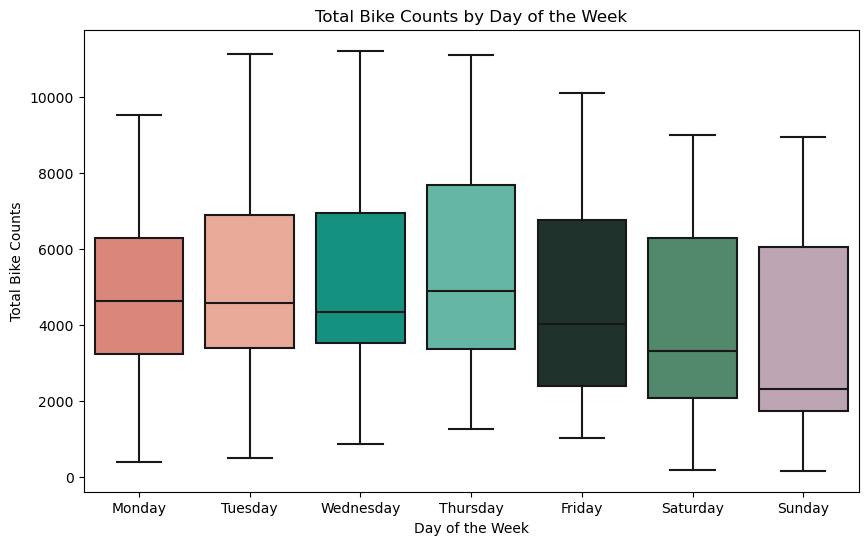

In [135]:
# Define your color palette
# Create the boxplot
sns.boxplot(x='DayOfWeek', y='Total', data=df_munich, palette=custom_palette)
plt.title('Total Bike Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Bike Counts')
plt.xticks(ticks=range(0, 7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

In [136]:
#df_m_e_2016 = df_location_erhardt[(df_location_erhardt["Date"] >= "2016-01-01") & (df_location_erhardt["Date"] < "2017-01-01")]
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(0, len(day_of_week)):
    mean = df_munich[(df_munich["DayOfWeek"] == i+1)]['Total'].mean().round(0)
    print('Mean for',day_of_week[i],":", mean)

Mean for Monday : 4945.0
Mean for Tuesday : 5215.0
Mean for Wednesday : 5199.0
Mean for Thursday : 5480.0
Mean for Friday : 4614.0
Mean for Saturday : 4108.0
Mean for Sunday : 3813.0


/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


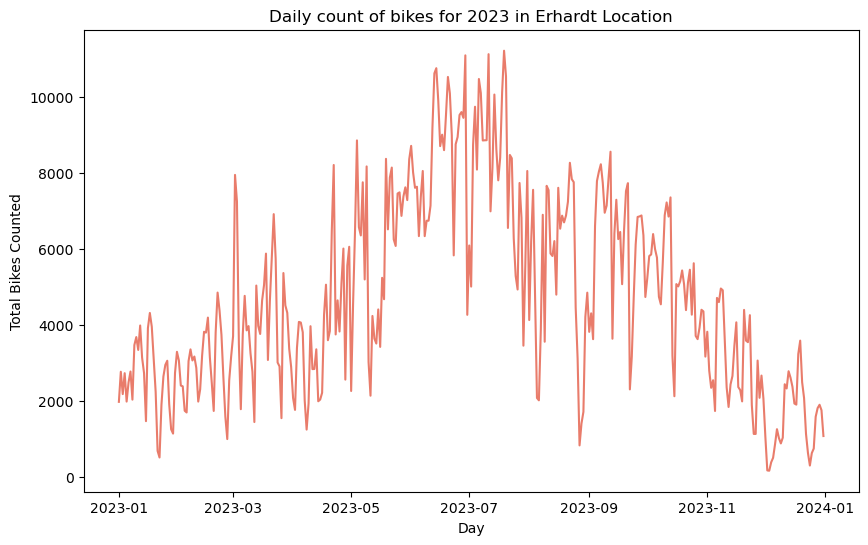

In [137]:
sns.lineplot(x='Date', y='Total', data=df_munich, color=custom_palette[0])
plt.title('Daily count of bikes for 2023 in Erhardt Location')
plt.xlabel('Day')
plt.ylabel('Total Bikes Counted')
plt.show()

In [138]:
# Sort the DataFrame by the 'Total' column in ascending order to get the lowest counts first
lowest_counts = df_munich.sort_values(by='Total').head(10)

# Sort the DataFrame by the 'Total' column in descending order to get the highest counts first
highest_counts = df_munich.sort_values(by='Total', ascending=False).head(10)

# Display the lowest counts
print("Top 10 lowest bike counts:")
print(lowest_counts)

# Display the highest counts
print("\nTop 10 highest bike counts:")
print(highest_counts)


Top 10 lowest bike counts:
          Date Location  Total  MinTemp  MaxTemp  AvgTemp  RainfallVolume  \
336 2023-12-03  Erhardt  160.0     -7.9     -1.1    -4.50             0.0   
335 2023-12-02  Erhardt  168.0     -5.5     -0.7    -3.10             6.8   
357 2023-12-24  Erhardt  297.0      6.6     12.2     9.40             5.8   
337 2023-12-04  Erhardt  381.0    -10.8     -2.3    -6.55             0.9   
338 2023-12-05  Erhardt  501.0     -3.0      6.2     1.60             0.4   
21  2023-01-22  Erhardt  509.0     -4.2     -1.3    -2.75             0.1   
358 2023-12-25  Erhardt  625.0      5.9     13.0     9.45             0.0   
356 2023-12-23  Erhardt  631.0      5.7      7.7     6.70             1.6   
20  2023-01-21  Erhardt  683.0     -3.6     -1.7    -2.65             4.5   
359 2023-12-26  Erhardt  744.0      2.9      9.3     6.10             0.0   

     DayOfWeek  
336          7  
335          6  
357          7  
337          1  
338          2  
21           7  
358   

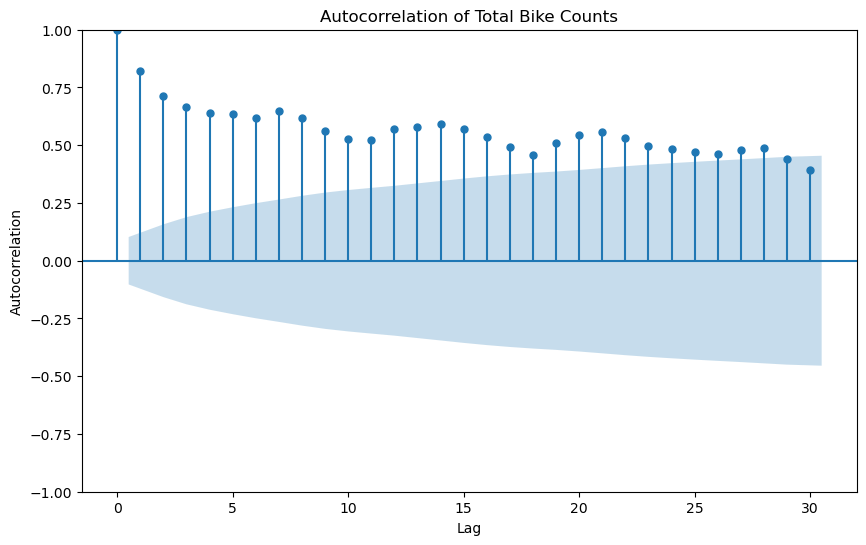

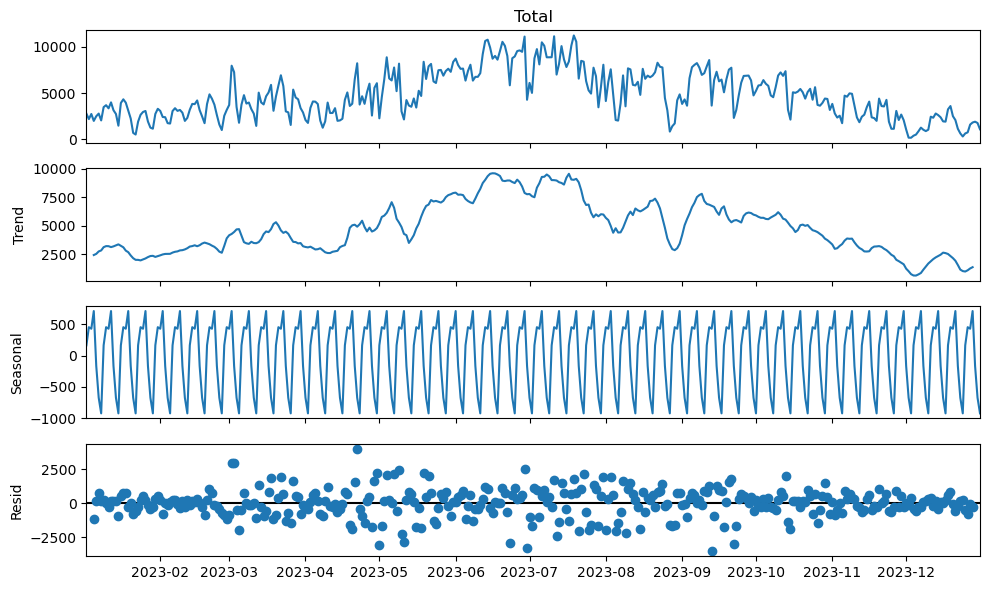

In [146]:
plot_acf(df_munich['Total'], lags=30, title='Autocorrelation of Total Bike Counts')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

## Some notes from Medium:
# The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF). In other words,
# >Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.
# >Autocorrelation measures the relationship between a variable’s current value and its past values.
# >An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.
# Important note: make sure your data doesn’t have NA values, otherwise the ACF will fail.

res = seasonal_decompose(df_munich['Total'], model = "additive",period = 7)
res.plot()
plt.show()

In [140]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_munich['Total'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

# Perform KPSS test
kpss_stat, p_value, lags, critical_values = kpss(df_munich['Total'])

# Print the results
print(f"KPSS Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: The time series is not stationary around a deterministic trend.")
else:
    print("Fail to reject the null hypothesis: The time series may be stationary around a deterministic trend.")


Results of Dickey Fuller Test:
Test Statistic                  -1.225828
p-value                          0.662388
#Lags Used                      13.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64
KPSS Statistic: 0.639204855906595
P-value: 0.019072285826673176
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Reject the null hypothesis: The time series is not stationary around a deterministic trend.


After differencing:
KPSS Statistic: 0.22052297699835027
P-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_35284/741959610.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat_diff, p_value_diff, lags_diff, critical_values_diff = kpss(df_munich['Total_diff'])


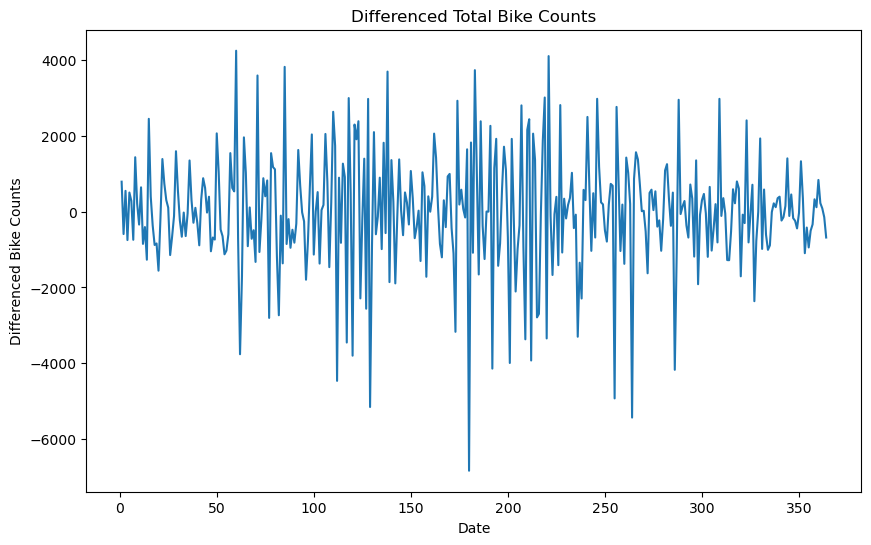

In [141]:
# Differencing the data and dropping NaN values
df_munich['Total_diff'] = df_munich['Total'].diff()
df_munich.dropna(inplace=True)  # Drop rows with NaN values

# Perform KPSS test on the differenced data
kpss_stat_diff, p_value_diff, lags_diff, critical_values_diff = kpss(df_munich['Total_diff'])

# Print the results
print("After differencing:")
print(f"KPSS Statistic: {kpss_stat_diff}")
print(f"P-value: {p_value_diff}")
print("Critical Values:")
for key, value in critical_values_diff.items():
    print(f"   {key}: {value}")

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(df_munich['Total_diff'])
plt.title('Differenced Total Bike Counts')
plt.xlabel('Date')
plt.ylabel('Differenced Bike Counts')
plt.show()


In [142]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_munich['Total_diff'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

# Perform KPSS test
kpss_stat, p_value, lags, critical_values = kpss(df_munich['Total_diff'])

# Print the results
print(f"KPSS Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: The time series is not stationary around a deterministic trend.")
else:
    print("Fail to reject the null hypothesis: The time series may be stationary around a deterministic trend.")


Results of Dickey Fuller Test:
Test Statistic                -6.248943e+00
p-value                        4.503434e-08
#Lags Used                     1.700000e+01
Number of Observations Used    3.460000e+02
Critical Value (1%)           -3.449392e+00
Critical Value (5%)           -2.869930e+00
Critical Value (10%)          -2.571240e+00
dtype: float64
KPSS Statistic: 0.22052297699835027
P-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Fail to reject the null hypothesis: The time series may be stationary around a deterministic trend.


/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_35284/3792895619.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(df_munich['Total_diff'])


## Models

In [144]:
df_munich.info()
time_series = df_munich['Total']

# Now time_series is a pandas Series containing the time series data

# Import ARIMA model from statsmodels
from statsmodels.tsa.arima.model import ARIMA

# Define the order for ARIMA model (p, d, q)
order = (1, 1, 12) 

# Instantiate ARIMA model
arima_model = ARIMA(time_series, order=order)

# Fit ARIMA model
arima_fit = arima_model.fit()

predictions = arima_fit.predict()

# Print summary of the model
print(arima_fit.summary())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 364 entries, 2023-01-02 to 2023-12-31
Freq: D
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Location        364 non-null    object 
 1   Total           364 non-null    float64
 2   MinTemp         364 non-null    float64
 3   MaxTemp         364 non-null    float64
 4   AvgTemp         364 non-null    float64
 5   RainfallVolume  364 non-null    float64
 6   DayOfWeek       364 non-null    int32  
 7   Total_diff      364 non-null    float64
dtypes: float64(6), int32(1), object(1)
memory usage: 24.2+ KB
                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  364
Model:                ARIMA(1, 1, 12)   Log Likelihood               -3129.477
Date:                Thu, 14 Mar 2024   AIC                           6286.955
Time:                        08:52:20   

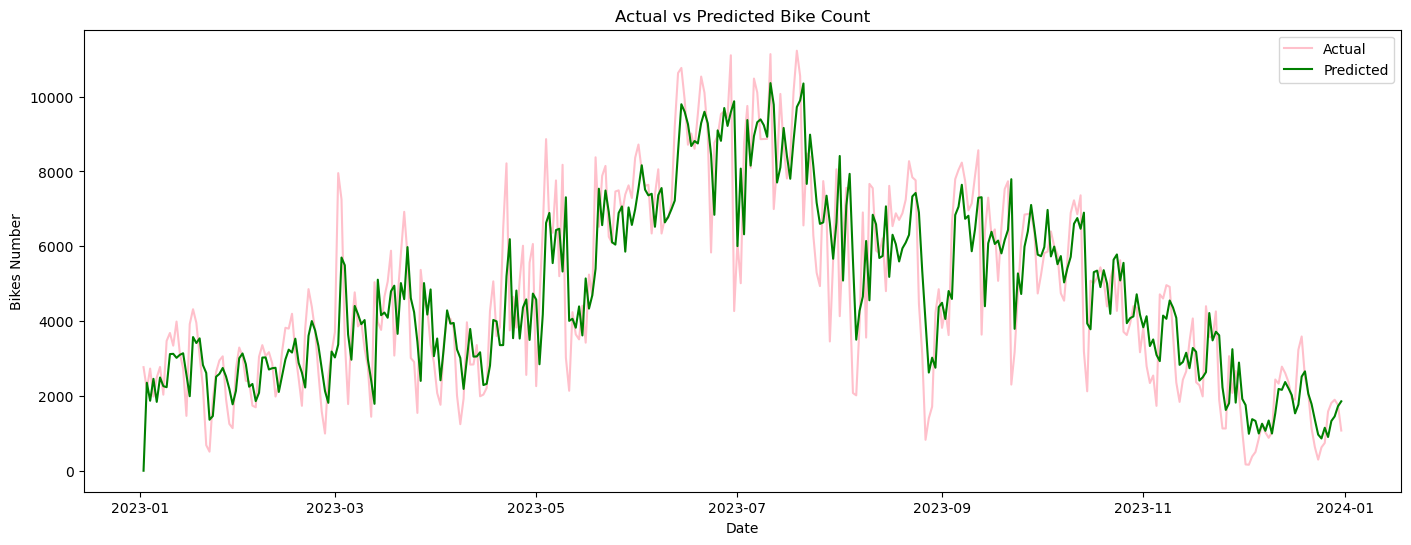

In [147]:
# Plot actual values and predictions
plt.figure(figsize=(17, 6))
plt.plot(time_series, label='Actual', color='pink')
plt.plot(predictions, color='green', label='Predicted')
plt.title('Actual vs Predicted Bike Count')
plt.xlabel('Date')
plt.ylabel('Bikes Number')
plt.legend()
plt.show()